<a href="https://colab.research.google.com/github/spencer18001/machine-learning-zoomcamp/blob/main/06/hw_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%%capture
!pip install tqdm
!wget -O jamb_exam_results.csv https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error
from tqdm.auto import tqdm

In [3]:
df_path = "jamb_exam_results.csv"
df = pd.read_csv(df_path)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [4]:
df.shape

(5000, 17)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
del df["student_id"]
df.fillna(0, inplace=True)

In [7]:
df.dtypes

,0
jamb_score,int64
study_hours_per_week,int64
attendance_rate,int64
teacher_quality,int64
distance_to_school,float64
school_type,object
school_location,object
extra_tutorials,object
access_to_learning_materials,object
parent_involvement,object


In [8]:
def data_split(df, random_state):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

In [9]:
df_train, df_val, df_test = data_split(df, random_state=1)
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

In [10]:
def one_hot_encode(df, dv, train):
    feature_dict = df.iloc[:, 1:].to_dict(orient='records')
    if train == True:
        X = dv.fit_transform(feature_dict)
    else:
        X = dv.transform(feature_dict)
    return X

In [11]:
def decision_tree_reg_fit(df, max_depth, dv):
    X = one_hot_encode(df, dv, train=True)
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X, df.iloc[:, 0].values)
    return model

In [12]:
dv = DictVectorizer(sparse=False)

In [13]:
dt_model = decision_tree_reg_fit(df_train, max_depth=1, dv=dv)

In [14]:
feature_names = list(dv.get_feature_names_out())
print(feature_names[dt_model.tree_.feature[0]]) # Q1
print(export_text(dt_model, feature_names=feature_names))

study_hours_per_week
|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



In [15]:
def random_forest_reg_fit(df, n_estimators, random_state, dv):
    X = one_hot_encode(df, dv, train=True)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
    model.fit(X, df.iloc[:, 0].values)
    return model

In [16]:
def random_forest_reg_predict(model, df, dv):
    X = one_hot_encode(df, dv, train=False)
    y_pred = model.predict(X)
    return y_pred

In [17]:
rf_model = random_forest_reg_fit(df_train, n_estimators=10, random_state=1, dv=dv)
y_pred = random_forest_reg_predict(rf_model, df_val, dv=dv)
root_mean_squared_error(df_val.iloc[:, 0], y_pred) # Q2

42.13724207871227

  0%|          | 0/20 [00:00<?, ?it/s]

(90,
 {10: 42.13724207871227,
  20: 41.46121464694444,
  30: 41.106170947924596,
  40: 40.917193933296545,
  50: 40.852278663496854,
  60: 40.78428140159447,
  70: 40.677098222414024,
  80: 40.53933283129176,
  90: 40.50434592594835,
  100: 40.51680451861919,
  110: 40.59335280539747,
  120: 40.6248503681005,
  130: 40.650840905587195,
  140: 40.5948515491302,
  150: 40.596715029667116,
  160: 40.60350763548252,
  170: 40.62754627591216,
  180: 40.641313925139386,
  190: 40.63135509073867,
  200: 40.60101912236933})

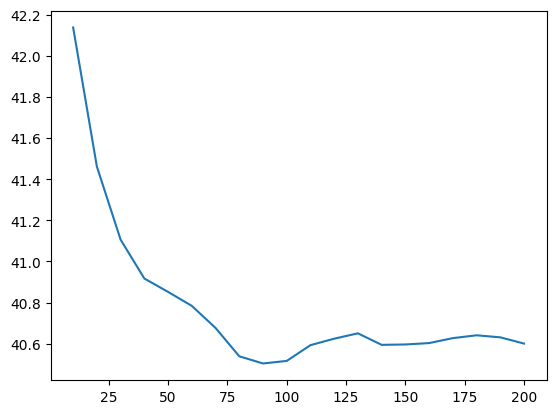

In [26]:
n_estimators_list = range(10, 201, 10)
rmse_list = []
for n_estimators in tqdm(n_estimators_list):
    rf_model = random_forest_reg_fit(df_train, n_estimators=n_estimators, random_state=1, dv=dv)
    y_pred = random_forest_reg_predict(rf_model, df_val, dv=dv)
    rmse_list.append(root_mean_squared_error(df_val.iloc[:, 0], y_pred))

plt.plot(n_estimators_list, rmse_list)
n_estimators_list[np.argmin(rmse_list)], dict(zip(n_estimators_list, rmse_list)) # Q3